### v6:
    * add u_in exponential 1-e**uin/max.
        * maybe use C as multiplier instead of R and experiment with e ratios
    * next, add log of u_in feature?

### v5:

   * Add RC feature (with spring above at .5): 1.0432, .780
   * Add R/C feature (with eqn above at .5): 1.027, .7752
   * Add C/R feature also (with eqn above at .5):  1.0276, .7743
   * added breath_id back: 1.0316, .77345
   * with second deriv = 1.013, .741  some improvement!  But why doesn't the corr reflect this?
   * catboost 10000 iterations: .677 !!! It is starting to increase better at higher iterations
   * 20000 iterations: .637 approaching the RF score (.61)
   * 30000 iterations! depth=6, .5887!!  But leaderboard was .70!  
       * **I guess that means overfitting!
   * with 3rd deriv and u_in_squared added: 1.0117, .7363, try rf: .50277 vs. .5846 lb...best so far
     * baselining for v5

### Previous Versions

Adding max u_in feature helped score from  ~.75 to ~.65.

Pipeline is:
* reduce memory
* split into two sets
* add features: max_time, max_u_in, dt, u_in_slope, u_in_area

Fork v1 adds u_in_ratio feature
* catboost drops a little 1.09 to ~1.065 ,didnt run rf.

Add 1/area feature since R decreases with increasing lung volume
   * helps a little, not much
   * with 1/R*area: 1.0727, .808181 
 
v4?
Add R(1-np.exp(-1*t/t_max)
   * spring R(1-np.exp(-1*time/time_max)): 1.0661, .7899
   * spring R(1-np.exp(-2*time/time_max)): 1.0612, .7857
   * spring R(1-np.exp(-3*time/time_max)): 1.0551, .7868
   * spring R(1-np.exp(-5*time/time_max)): 1.0575, .7847
   * spring R(1-np.exp(-R*time/time_max)): 1.0529, .7877
   * spring R(1-np.exp(-.5*R*time/time_max)): 1.0541, .7842
   * spring R(1-np.exp(-.2*R*time/time_max)): 1.0549, .7854


# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import platform
pd.options.mode.chained_assignment = None

# Functions

In [2]:
# function to get single breath (id must exist...there are some that are missing)
# also once removed u_out=1, lengths are not always 30 (some 28, etc)
def get_breath(df,my_id):
    return df[df.breath_id == my_id] 

In [3]:
def plot_breath(df,my_id):
    id1 = get_breath(df,my_id)
    r = id1.R.iloc[0]
    c = id1.C.iloc[0]
    plt.figure(figsize=(8,5))
    plt.plot(id1.pressure,label='pressure')
    plt.plot(id1.u_in,label='u_in')
    plt.title(f'Pressure and u_in for Breath id={my_id}, R={r}, C={c}')
    plt.legend();

# Load Files

In [340]:
%%time
# Load files
if platform.system() == 'Windows' and platform.release() == '7':
    drive = 'F'
elif platform.system() == 'Windows' and platform.release() == '10':
    drive = 'C'
    
train = pd.read_csv(drive + r':\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\train.csv')
test = pd.read_csv(drive + r':\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\test.csv')
    
#train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
#test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

y = train['pressure']


Wall time: 4.89 s


# Memory Reduction

In [341]:
# down convert columns to save memory...
def reduce_memory(df):
    
    print(f'Initial memory usage: {df.memory_usage().sum()/1024**2:0.1f}GB')
    df['id'] = df['id'].astype(np.int32)
    df['breath_id'] = df['breath_id'].astype(np.int32)
    df['R'] = df['R'].astype(np.int8)  #or OHC?
    df['C'] = df['C'].astype(np.int8)
    df['u_out'] = df['u_out'].astype(np.int8)
    df['u_in'] = df['u_in'].astype(np.float32)
    df['time_step'] = df['time_step'].astype(np.float32)
    print(f'New memory usage: {df.memory_usage().sum()/1024**2:0.1f}GB')
    
    # somewhere else I printed out a reduction as well.
    
#     for col in test.columns:
#         print(test[col].dtype)

In [342]:
print('Train:')
reduce_memory(train)
print('Test:')
reduce_memory(test)


Train:
Initial memory usage: 368.4GB
New memory usage: 155.4GB
Test:
Initial memory usage: 214.9GB
New memory usage: 72.9GB


# Split data into inhalitory and exhalitory phase (only scored on inhale)

In [534]:
train_in = train[train.u_out == 0]
test_in = test[test.u_out == 0]
y_in = train_in['pressure']

train_out = train[train.u_out == 1]
test_out = test[test.u_out == 1]

In [535]:
# make an index of breaths
train_breath_idx = train_in.breath_id.unique()
test_breath_idx = test_in.breath_id.unique()
test_breath_idx

array([     0,      8,     11, ..., 125746, 125747, 125748])

In [536]:
# u_in leaking into next breath...number leaked = 
transitions = np.where(np.diff(train_in.breath_id) == 1)
transitions[0]
# for r in transitions[0]:
#     print(train_in.u_in_lag.iloc[r+1])

array([     29,      58,      90, ..., 2290785, 2290817, 2290876],
      dtype=int64)

#  Add Features

    1. Apply lag shift (tested shift =1 ) 
        Shift = 2 performs better (2.37 vs. 2.0x)
    2. Add differentials for dt and du_in
    3. Add integral column for d_uin



In [537]:
# first add max_u_in value before lag shift
#train_in["max_u_in"] = train_in.groupby("breath_id")["u_in"].transform("max")
#test_in["max_u_in"] = test_in.groupby("breath_id")["u_in"].transform("max")

# train_in["u_in_ratio"] = train_in.u_in/train_in.max_u_in
# test_in["u_in_ratio"] = test_in.u_in/test_in.max_u_in
# train_in["u_in_ratio"] = train_in.u_in_ratio.fillna(0)
# test_in["u_in_ratio"] = test_in.u_in_ratio.fillna(0)


In [538]:
#train_in
#train_in.inv_area.isinf().sum()
#np.isinf(train_in).values.sum()

### Apply lag shift, Add Differential, Integral, and other Features

In [542]:
def apply_features(df,ushift):
    
    # apply lag shift
    shift = ushift
    u_in_lag = df.u_in.shift(shift,fill_value=0)
    df.loc[:,'u_in_lag'] = u_in_lag.copy()

    # max/min features
    df["max_u_in"] = df.groupby("breath_id")["u_in"].transform("max")
    df["max_time"] = df.groupby("breath_id")["time_step"].transform("max")
    
    # ratios
    df["u_in_ratio"] = df.u_in/train_in.max_u_in
    df["u_in_ratio"] = df.u_in_ratio.fillna(0)
    df['RC'] = df.R * df.C
    df['RoverC'] = df.R/df.C
    df['CoverR'] = df.C/df.R
    
    # dt
    df['dt'] = df['time_step'].diff()
    df['dt'].fillna(0, inplace=True)  # no na values so not needed
    df['dt'].mask(df['dt'] < 0,0,inplace=True) #df.groupby('breath_id')['dt'].mean(), inplace=True)  #makes
    
    # derivatives   
    df['du_in'] = df['u_in_lag'].diff()  # then look where time delta is 0 and make this 0 also
    df['du_in'].mask(df['dt'] == 0, 0, inplace=True)
    #df['dt'].fillna(0, inplace=True)
    df['du2_in'] = df['du_in'].diff()
    df['du2_in'].mask(df['dt'] == 0, 0, inplace=True)
    df['du3_in'] = df['du2_in'].diff()
    df['du3_in'].mask(df['dt'] == 0, 0, inplace=True)

    # integration
    df['d_area'] = df['dt'] * df['u_in_lag']
    df['u_in_area'] = df.groupby('breath_id')['d_area'].cumsum()#.shift(1,fill_value=0)
    df['inv_area'] = 1/(df.C*df['u_in_area'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['inv_area'].fillna(0, inplace=True)
    df['u_in_sq'] = df.u_in_lag * df.u_in_lag
    df['u_in_cube'] = df.u_in_lag**3/1000

    # formulas
    df['R_spring'] = df.R*(1-np.exp((-.5*df.R*df.time_step)/df.max_u_in))
    df['U_spring'] = df.C*(1-np.exp((-.05*df.C*df.u_in_lag)/df.max_u_in))
    df['R_spring'].fillna(0, inplace=True)
    df['U_spring'].fillna(0, inplace=True)

    # Drop unused axes
    df.drop(['d_area'],axis=1,inplace=True)
    df.drop(['u_in'],axis=1,inplace=True)


In [543]:
apply_features(train_in,1)
apply_features(test_in,1)

In [544]:
#np.isinf(train_in).values.sum()
#train_in.isna().sum()

id            0
breath_id     0
R             0
C             0
time_step     0
u_out         0
pressure      0
u_in_lag      0
max_u_in      0
max_time      0
u_in_ratio    0
RC            0
RoverC        0
CoverR        0
dt            0
du_in         0
du2_in        0
du3_in        0
u_in_area     0
inv_area      0
u_in_sq       0
u_in_cube     0
R_spring      0
U_spring      0
dtype: int64

Visualize features

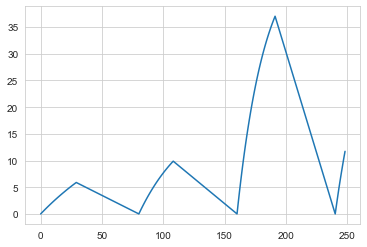

In [545]:

plt.plot(train_in.R_spring[0:100])


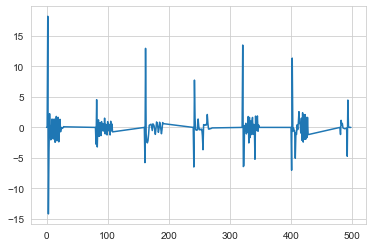

In [546]:
plt.plot(train_in.du2_in[0:200])

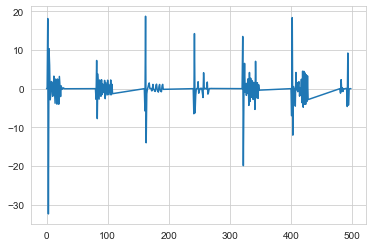

In [547]:
plt.plot(train_in.du3_in[0:200])

In [548]:
#plt.plot(train_in.u_in_cube[0:100])

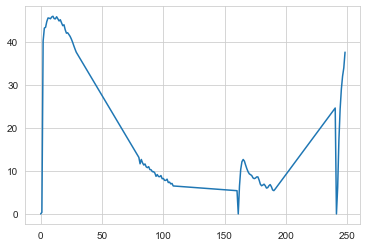

In [549]:
plt.plot(train_in.U_spring[0:100])

In [550]:
#train_in.head(33)

In [551]:
# this doesn't seem to be useful in selecting features.
#plt.figure(figsize=(17,15))
#sns.heatmap(train_in.corr(),annot=True)
#plt.savefig('heatmap',dpi=300)

# Model

In [552]:
from sklearn.metrics import mean_absolute_error  #confusion_matrix, classification_report

## Need to ditch split and go to cross validation

In [553]:
# Split data - after all analysis is done
from sklearn.model_selection import train_test_split

test_drop_cols = ['id','breath_id','u_out','dt']
train_drop_cols = test_drop_cols.copy()
train_drop_cols.append('pressure')

train_in.drop(columns = ['id','u_out','pressure'], inplace = True)
#test = test.drop(columns = 'id', inplace = True)

X_train, X_valid, y_train, y_valid = train_test_split(train_in, y_in, train_size=0.8, test_size=0.2,
                                                      random_state=12)
X_test_in = test_in.drop(columns=['id','u_out'],inplace=False)

In [554]:
#test_in.head()

In [555]:
%%time
from catboost import CatBoostRegressor
# loop for manual type cv
#preds = []
for i in [400,4000]:
#     X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, test_size=0.2,
#                                                       random_state=i)
    model_cat = CatBoostRegressor(loss_function="MAE",
                               eval_metric="MAE",
                               task_type="GPU",
                               learning_rate=.6,
                               iterations=i,
                               l2_leaf_reg=50,
                               random_seed=12,
                               #od_type="Iter",
                               depth=5,
                               #early_stopping_rounds=6500,
                               #border_count=64,
                               verbose=False
                              )
    model_cat.fit(X_train,y_train)
    pred_cat = model_cat.predict(X_valid)
    score_cat = mean_absolute_error(y_valid,pred_cat)
    #print(f'iters={i}, lr={j}, CatBoost MAE Score: {score_cat}')
    print(f'CatBoost MAE Score: {score_cat}')
    #preds.append(model_cat.predict_proba(X_test)[:,1])
    # 400, .6 = 3.976 
    # with deriv, integral
    # 400, .6 = 1.42
    # 4000,.6 = 1.21 (1.18 lb)
    # 8000,.6 = 1.12 (1.14 lb) maybe starting to overfit
    # shift = 1 (still need to review lining up)
    # 400, .6 = 1.22
    # 4000: 1.1277 
    # try shift = 2, = 1.23 with 4000,.6 (worse)
    
    # again...
    # shift 1 = 1.287 with 400, .6 (1.33 with older method..shifting integral better?)
    # shift 1 = 1.0773 with 4000, .6, so it is a little better than the 1.1227 with the older method
    # removed NaN from dt, integ and is a little worse. 1.079 ()
    # 1.1943 with max_time added and 400 iters, rt = .65!
    # adding d_area column, 400,.6 mae = 1.1987 (slightly higher)
    # 4000 = .9679  what was it previosly?  Forgot to run (or record).
    # Next, study of l2_leaf_reg 5-45 in 5 inc: virtually no change: 1.1947-1.195x
    # Removed some other parameters. 400, .77 = 1.653, 4000, .77 = .943
    # 4000, .057: .9404
    # try some more lr values at 4000 iters .2 to .8 in .01 increments.  Not much improvement compared to rf: .985-.935
    # Best prev: 16000, .71,45,20 = .86958   ...still not competitive with random forest


    # 400, .6,50,5 = 1.09! , 4000 = .833!  this is lower..._adding max_u_in helped!
    
    # add u_in ratio...if I fill na with zeros, 400, 4000:
    # CatBoost MAE Score: 1.1315940327192697, 0.8594030798739087
    # if I don't fill na in u_in_ratios:
    # CatBoost MAE Score: 1.125316246725629, 0.8638797903427912
    # add dt col back
    # CatBoost MAE Score: 1.0696357140212032, 0.8173306530838652
    # remove nans again...acutally a little better
    # CatBoost MAE Score: 1.0640880797871226, 0.8171753258386951
    # with just 1/area: 1.08, .823
    # with R/area: 1.0753, .808912
    # with 1/R*area: 1.0727, .808181  ...nearly the same but marginally lower at 4000, check rf
    # again...1.08737, .0804.  Since this is the lowest so far, I am going to run rf.  Maybe try 8k catboost runs
    # spring R(1-np.exp(-1*time/time_max)): 1.0661, .7899
    # spring R(1-np.exp(-2*time/time_max)): 1.0612, .7857
    # spring R(1-np.exp(-3*time/time_max)): 1.0551, .7868
    # c
    # spring R(1-np.exp(-R*time/time_max)): 1.0529, .7877
    # spring R(1-np.exp(-.5*R*time/time_max)): 1.0541, .7842
    # spring R(1-np.exp(-.2*R*time/time_max)): 1.0549, .7854
    # Add RC feature (with spring above at .5): 1.0432, .780
    # Add R/C feature (with eqn above at .5): 1.027, .7752
    # Add C/R feature also (with eqn above at .5):  1.0276, .7743
    # added breath_id back: 1.0316, .77345
    # with second deriv = 1.013, .741  some improvement!  But why doesn't the corr reflect this?
    
    # catboost 10000 iterations: .677 !!! It is starting to increase better at higher iterations
    # 20000 iterations: .637 approaching the RF score (.61)
    # 30000 iterations! depth=6, .5887!!  But leaderboard was .70!  I guess that means overfitting!

    # with 3rd deriv and u_in**2 added: 1.0117, .7363, try rf: .50277 vs. .5846 lb...best so far
    
    # Add u_spring:
    # spring_u =  R(1-np.exp(-.1*R*u_in/u_in_max)): 1.00894, .73708
        # not really much improved, but this uses R values, try with just C
    # spring C(1-np.exp(-u_in/u_in_max)): 1.02188,.73911
    # try not dropping u_in: 1.0209, .742 (basically no diff)
    # u_in back, no R in exponent, R(1-np.exp(-u_in/u_in_max)): 1.01559, .7396
    # spring_u =  R(1-np.exp(-.1*C*u_in/u_in_max)): 1.0074, .7368
    # spring_u =  C(1-np.exp(-.1*C*u_in/u_in_max)): 1.0210, .7406
    # spring_u =  C(1-np.exp(-.05*C*u_in/u_in_max)): 1.0113, .7343
    # add u_in_cubed: 1.015, .740 (not any better)
    # spring_u =  C(1-np.exp(-.05*C*u_in/u_in_max)): 1.0152, .7395
    # same, divide cube by 1000 (exact same results). should remove cube
    # just re-check, lag = 2 with above = 1.064, .8071, yep, worse
    # anothe re-check, lag = 0 with above = 1.045, .765 yep, worse
    # spring_u =  C(1-np.exp(-.05*C*u_in/u_in_max)): 1.017, .7423
    # remove u_in_cube same as above: 1.0208, .7416??? why not back to .7343?
    
    #check params again no inv_area: 1.0245, .74788
    # inv_area = 1/C, corr says very low, but better: 1.0135, .7417
    # switching to depth=6 makes scores better for cb: .9365, .697
    # wrote function for applying features, 
    
    # .937, .695 with depth = 6
    # 1.015, .743 with depth = 5
    # .8792, .66252 with depth = 7
    # .8299, .6366 with depth = 8
    # depth = 9 takes too long
    # using add features function, depth = 8
    # .832, .6374 # a little different..but prob close enough 
    
    # had na's in data, both R_spring and U_spring
    

CatBoost MAE Score: 1.0162090477540486
CatBoost MAE Score: 0.744951160481895
Wall time: 1min 30s


In [522]:
# grid search
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

#instantiate the model
model_cbcv = CatBoostRegressor(verbose=False, task_type='GPU')
#create the grid
grid = {'max_depth': [6,7,8],'n_estimators':[4000, 8000, 12000]}
# instantiate gridsearchcv
gscv = GridSearchCV (estimator = model_cbcv, param_grid = grid, scoring ="neg_mean_absolute_error", cv = 5)
gscv.fit(train_in,y_in)

print(gscv.best_estimator_)
print(gscv.best_score_)
print(gscv.best_params_)

# best score shows -.7165, but lb shows .79xx


-0.7165218668753083
{'max_depth': 8, 'n_estimators': 12000}


In [523]:
gscv.cv_results_


{'mean_fit_time': array([ 70.98353391, 142.03304429, 213.04435267,  81.59239864,
        162.62824383, 243.20427928,  91.77267427, 182.34494777,
        272.92680454]),
 'std_fit_time': array([0.19786296, 0.31404134, 0.31082879, 0.19482327, 0.21284259,
        0.42127585, 0.20534299, 0.35190318, 0.63724533]),
 'mean_score_time': array([0.35754318, 0.69918079, 1.01071763, 0.38906293, 0.81276608,
        1.14423752, 0.48918071, 0.99351263, 1.47833476]),
 'std_score_time': array([0.02187675, 0.02255026, 0.04902073, 0.02522246, 0.04266229,
        0.05224105, 0.0269299 , 0.03680996, 0.02800985]),
 'param_max_depth': masked_array(data=[6, 6, 6, 7, 7, 7, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[4000, 8000, 12000, 4000, 8000, 12000, 4000, 8000,
                    12000],
              mask=[False, False, False, False, False, Fa

In [524]:
pred_cv_final = gscv.predict(test_in)

In [529]:
%%time
#random forest - trying to convert to catboost
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_valid)
rf_mae = mean_absolute_error(pred_rf,y_valid)
print(f'Random Forest MAE Score: {rf_mae}')

# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12), mae=3.12775, lb score = 6.431(?)
# Why is random forest worse?  
# 10/17/21: Still worse after using only inhales
# defaults: runs out of memory!!!???
# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12) = 5.867
# reduced dtype sizes on ints: 
# 3.627 default, lb = 3.710
# changed criterion to mae...doesn't work...removed

# with dt and du_in, shift=1, 2.364 vs. lb of 2.37.  Beats catboost (400,.6)
# with dt and du_in, shift=2, Random Forest MAE Score: 2.058162936194095
# with dt and du_in, shift=3, Random Forest MAE Score: 2.03014981349922
# interesting shift 3 is a little better.

# deriv and integral, shift=1, .7934!!!
# but leaderboard was .8897
# try shift = 2, = .934 (a little lower)
# added max_time column, down to .6429!  
# added d_area column - actually increased a little to .64394, but possible that lb is better...maybe try it.
# added max_u_in (in addition to max_time), .55379
# with ratio 1/R*area increase a little: .53347, lb score improved a bit to .61
# with RC, etc... .53109, .61 lb .6105 vs .6144ish
# with 3rd derivative and u_in squared:  .50277 vs. .5846 lb...best so far

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# Final Model Submission

In [525]:
#pred_final = model_rf.predict(X_test_in)
pred_cv_final = gscv.predict(test_in)
# add indexs to recombine with out preds
#pred_final_s = pd.Series(pred_final,index=list(test_in.id))
pred_final_s = pd.Series(pred_cv_final,index=list(test_in.id))
pred_final_s.head()

1    6.609319
2    6.199213
3    6.998475
4    7.874464
5    9.135360
dtype: float64

In [526]:
# create outpreds = just ones
out_preds = np.ones(len(test_out))
i = list(test_out.id)
out_preds_s = pd.Series(out_preds,index = i)
out_preds_s

32         1.0
33         1.0
34         1.0
35         1.0
36         1.0
          ... 
4023996    1.0
4023997    1.0
4023998    1.0
4023999    1.0
4024000    1.0
Length: 2496435, dtype: float64

In [527]:
both = pred_final_s.append(out_preds_s).sort_index()
both.values

array([6.60931863, 6.19921286, 6.99847454, ..., 1.        , 1.        ,
       1.        ])

In [528]:
output = pd.DataFrame({'id': test.id, 'pressure': both.values})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!


## Post Analyze prediction vs. actuals and look for trends

In [31]:
# %%time
# ### predictions vs. validation data
pred_rf_all = model_rf.predict(train_in)

In [32]:
y_in.values

array([ 5.83749171,  5.90779385,  7.87625392, ..., 29.88082545,
       29.38871043, 30.09173189])

In [33]:
#Create a dataframe with breath_id's to make plotting easier
post_analysis = pd.DataFrame({'breath_id': train_in.breath_id, 'prediction': pred_rf_all, 'acutal': y_in.values})
post_analysis['residual'] = pred_rf_all - y_in.values
post_analysis['R'] = train_in.R
post_analysis['C'] = train_in.C
post_analysis['u_in_lag'] = train_in.u_in_lag


In [34]:
# post_analysis.head()

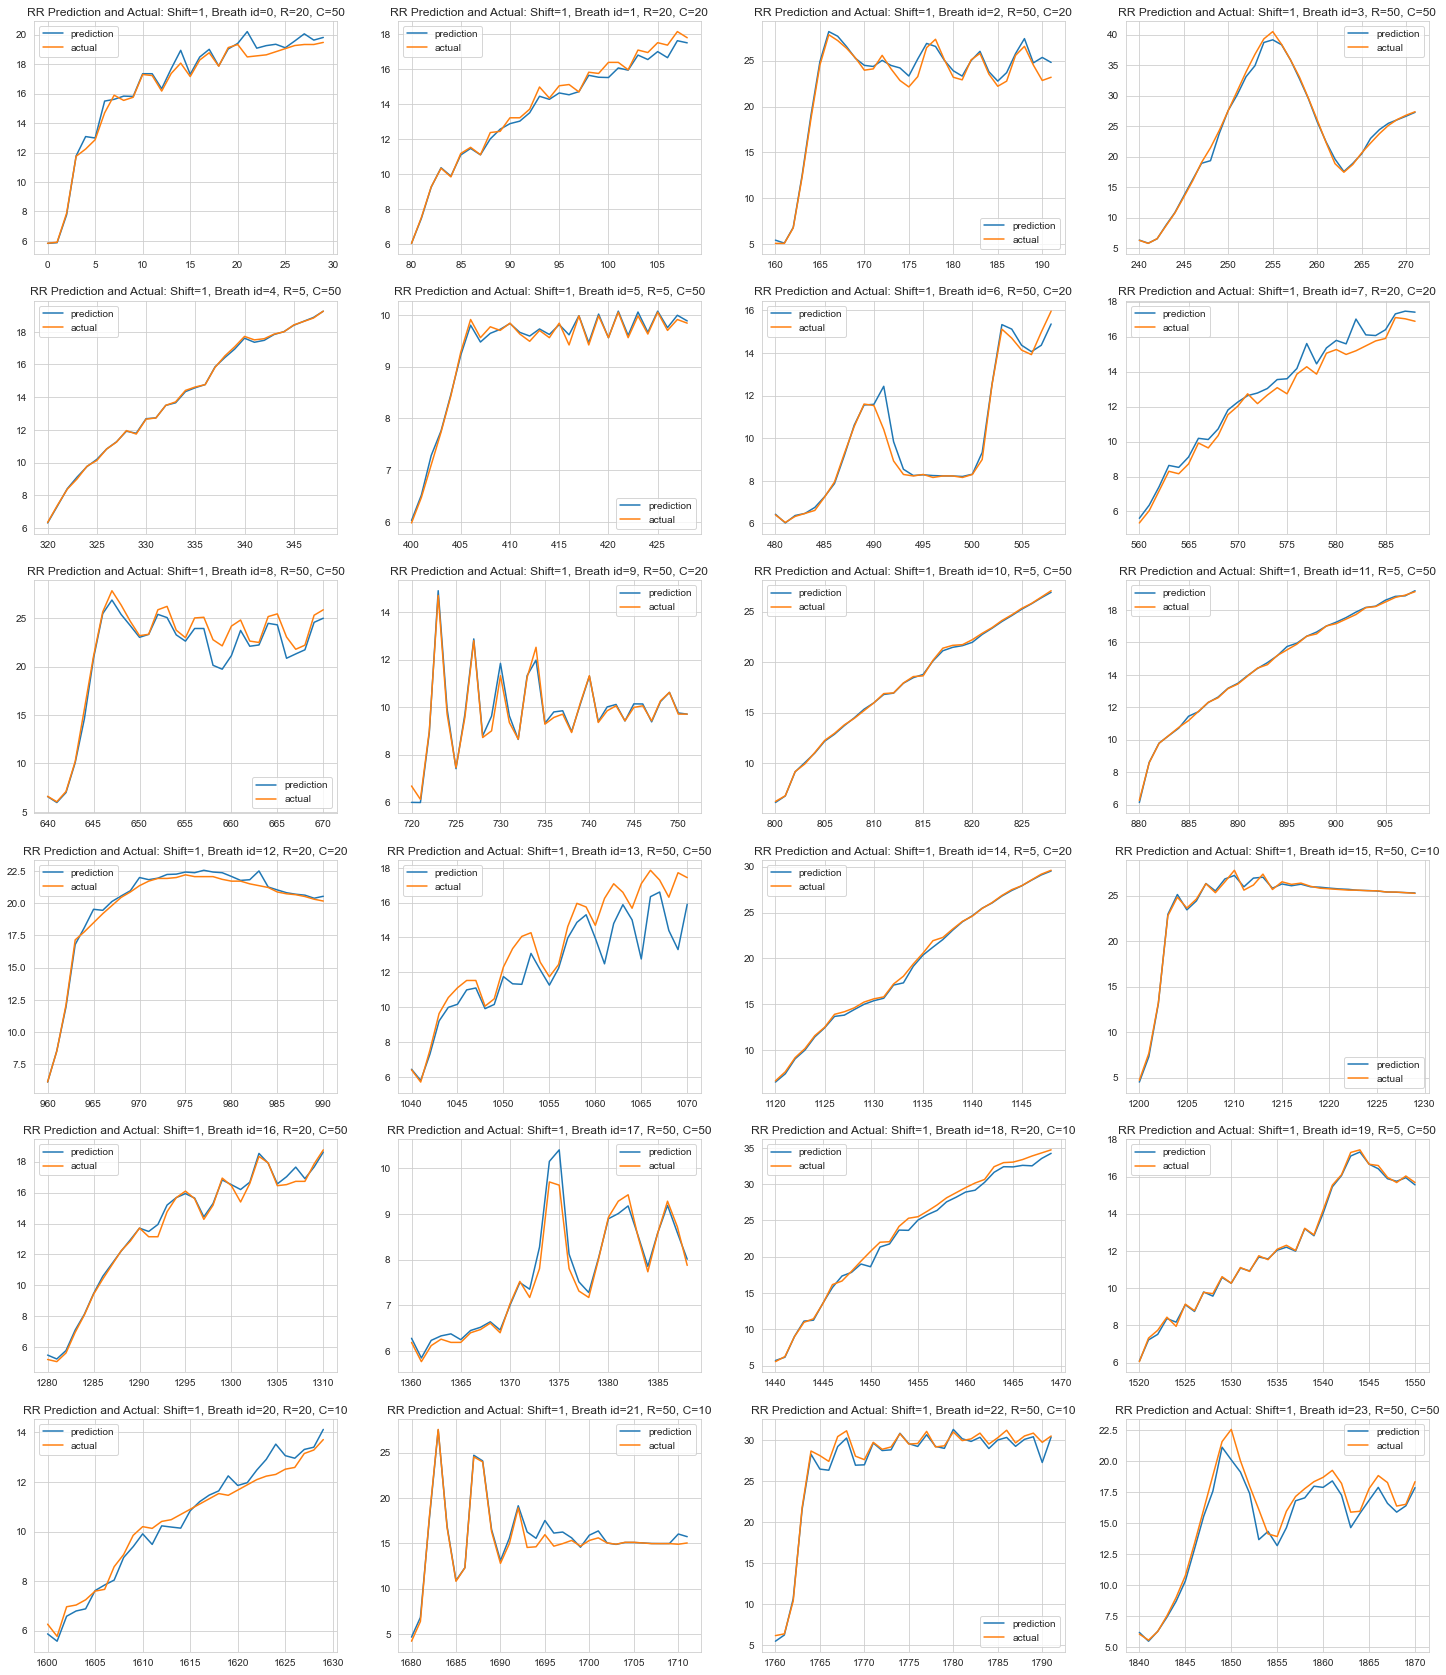

In [35]:
# make this a function
breath_idx = train_in.breath_id.unique()
fig, ax = plt.subplots(6, 4, figsize=(25,30))
ax = ax.flatten()
for i in range(24):
    b_id = get_breath(post_analysis,breath_idx[i])
    r = b_id.R.iloc[0]
    c = b_id.C.iloc[0]
    ax[i].plot(b_id.prediction,label='prediction')
    ax[i].plot(b_id.acutal,label='actual')
    ax[i].set_title(f'RR Prediction and Actual: Shift=1, Breath id={i}, R={r}, C={c}')
    ax[i].legend();
    
#plt.savefig('RndFrst_pred_actual_shift=1_tot_time.png')


ValueError: Found input variables with inconsistent numbers of samples: [6036000, 1527565]